# Evaluating model and interpret the classification results

In [47]:
import torchray
import torch
import attr
from pathlib import Path
from torchvision import datasets, transforms
from torchray.benchmark import get_example_data, plot_example
from torchvision import models
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics as sk_metrics
from torchray.attribution.common import Probe, get_module
from torchray.attribution.grad_cam import grad_cam
from torchray.attribution.grad_cam import gradient_to_grad_cam_saliency
from PIL import Image

In [2]:
@attr.s(auto_attribs=True)
class DataPreparation:
    data_dir: Path
    device: str = attr.ib(default=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), init=False)

    @staticmethod
    def data_transformations():
        data_transforms = {
            'test': transforms.Compose([
                transforms.CenterCrop((200, 1500)),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        }
        return data_transforms
    
    def create_dataloaders(self, batch_size, shuffle, num_workers):
        data_transforms = self.data_transformations()
        
        image_datasets = {
            'test': datasets.ImageFolder(self.data_dir, data_transforms['test'])
        }
        dataloaders = {
            'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
        }
        dataset_sizes = {
            'test': len(image_datasets['test'])
        }
        return dataloaders, dataset_sizes


In [3]:
data_prep = DataPreparation('../data/figures/test')
data, size = data_prep.create_dataloaders(16, False, 4)

In [5]:
# model_path = Path().cwd().parents[0] / "models/resnet50_d_28_t_15_49.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_02_34.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_13_14.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_14_58.pth"
# model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_17_14.pth" # without pretrained only one learning rate
model_path = Path().cwd().parents[0] / "models/resnet50_d_29_t_18_06.pth" # with pretrained only one learning rate

In [6]:
model = torch.load(model_path)
model.eval();

In [7]:
def deprocess(image):
    transform = transforms.Compose([
        transforms.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        transforms.ToPILImage(),
    ])
    return transform(image)

def show_img(PIL_IMG):
    plt.imshow(np.asarray(PIL_IMG))

In [38]:
i = 0
for inputs, labels in data['test']:
    inputs = inputs.to(0)
    labels = labels.to(0)
    x = inputs
    break
#     x.requires_grad_();
#     scores = model(x)
#     score_max_index = scores.argmax(dim=1)
#     score_max = scores[:, score_max_index]
#     score_max.backward(torch.ones_like(score_max))
#     saliency, _ = torch.max(x.grad.data.abs(),dim=1)
    
#     for index in range(len(saliency)): 
#         plt.figure()
#         img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7);
#         img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4);
#         plt.axis('off')
#         if labels[index] == 0:
#             label = "abnormal"
#         else:
#             label = "normal"
#         plt.savefig(f"../saliency_maps/pretrain_false_1lr/{label}/{i}_{index}.png")
        
#     i += 1

In [10]:
x.size()

torch.Size([16, 3, 224, 224])

In [50]:
x.requires_grad_();
scores = model(x)

In [51]:
print(f"Scores\tLabels\n{scores}\t{labels}")

Scores	Labels
tensor([[ 1.1979, -1.1999],
        [-1.2643,  1.2626],
        [ 0.8310, -0.8330],
        [ 0.8338, -0.8358],
        [ 1.3873, -1.3894],
        [ 0.9853, -0.9874],
        [ 1.4753, -1.4774],
        [ 1.5320, -1.5342],
        [ 0.9109, -0.9130],
        [ 0.9908, -0.9929],
        [ 0.9722, -0.9743],
        [ 0.9685, -0.9705],
        [ 1.1157, -1.1177],
        [ 0.4415, -0.4434],
        [ 1.1255, -1.1275],
        [ 1.2071, -1.2091]], device='cuda:0', grad_fn=<AddmmBackward>)	tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


In [52]:
score_max_index = scores.argmax(dim=1)
print(f"SCORE MAX INDEX: {score_max_index}")
score_max = scores[:, score_max_index]
print(f"SCORE MAX: {score_max}")

'''
backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
score_max with respect to nodes in the computation graph
'''
score_max.backward(torch.ones_like(score_max))
# score_max.backward()

'''
Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
across all colour channels.
'''
saliency, _ = torch.max(x.grad.data.abs(),dim=1)

SCORE MAX INDEX: tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
SCORE MAX: tensor([[ 1.1979, -1.1999,  1.1979,  1.1979,  1.1979,  1.1979,  1.1979,  1.1979,
          1.1979,  1.1979,  1.1979,  1.1979,  1.1979,  1.1979,  1.1979,  1.1979],
        [-1.2643,  1.2626, -1.2643, -1.2643, -1.2643, -1.2643, -1.2643, -1.2643,
         -1.2643, -1.2643, -1.2643, -1.2643, -1.2643, -1.2643, -1.2643, -1.2643],
        [ 0.8310, -0.8330,  0.8310,  0.8310,  0.8310,  0.8310,  0.8310,  0.8310,
          0.8310,  0.8310,  0.8310,  0.8310,  0.8310,  0.8310,  0.8310,  0.8310],
        [ 0.8338, -0.8358,  0.8338,  0.8338,  0.8338,  0.8338,  0.8338,  0.8338,
          0.8338,  0.8338,  0.8338,  0.8338,  0.8338,  0.8338,  0.8338,  0.8338],
        [ 1.3873, -1.3894,  1.3873,  1.3873,  1.3873,  1.3873,  1.3873,  1.3873,
          1.3873,  1.3873,  1.3873,  1.3873,  1.3873,  1.3873,  1.3873,  1.3873],
        [ 0.9853, -0.9874,  0.9853,  0.9853,  0.9853,  0.9853,  0.9853,  0.9853,
  

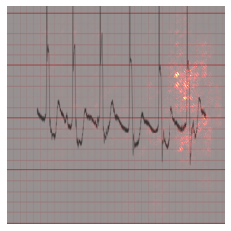

In [53]:
index = 4
# code to plot the saliency map as a heatmap
plt.figure()
img1 = plt.imshow(saliency[index].cpu().numpy(), cmap=plt.cm.hot, alpha=.7)
# plt.axis('off')
# plt.show()
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

In [67]:
x[index].detach().cpu().numpy()

(3, 224, 224)

In [68]:
x_img = Image.fromarray(x[index].detach().cpu().numpy(), 'RGB')

In [96]:
map_sal = Image.fromarray(saliency[index].cpu().numpy().reshape((224,224,3)), 'RGB')

ValueError: cannot reshape array of size 50176 into shape (224,224,3)

In [94]:
map_sal.size

(224, 1)

In [74]:
Image.blend(x_img, map_sal, alpha=0.5)

ValueError: images do not match

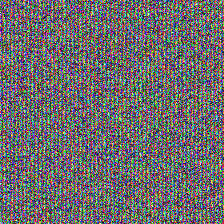

In [72]:
newimg1

In [26]:
deprocess(x[index].cpu()).save("test.png")

In [13]:
saliency[index].mean()

tensor(0.0011, device='cuda:0')

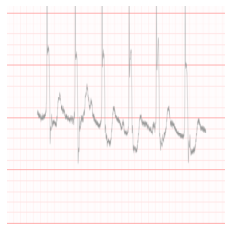

In [14]:
img2 = plt.imshow(deprocess(x[index].cpu()), alpha=.4)
plt.axis('off')
plt.show()

-------------------------------------------------------------------------------------------------

In [ ]:
saliency_layer = get_module(model, model.avgpool)
probe = Probe(saliency_layer, target='output')
y = model(x)
z = y[0, labels[0]]
z.backward();

In [ ]:
print(model.children)

In [ ]:
print(probe.data[0].size())
saliency = gradient_to_grad_cam_saliency(probe.data[0])
# Plots.
plot_example(x, saliency, 'grad-cam backprop', labels, save_path='saliency.pdf')

In [ ]:
# Grad-CAM backprop.
saliency = grad_cam(model, x, labels, saliency_layer=model.layer4)

# Plots.
# plot_example(x, saliency, 'grad-cam backprop', labels)

print(saliency.size())

plt.imshow(deprocess(saliency[index]).cpu().detach().numpy())
plt.axis('off')
plt.show()